## TimeSeries_Basic_Training

https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts

In [1]:
# basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Time series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf, arma_order_select_ic
import statsmodels.formula as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# setting
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import all of them 
sales=pd.read_csv("./sales_train.csv")

# settings
import warnings
warnings.filterwarnings("ignore")

item_cat=pd.read_csv("./item_categories.csv")
item=pd.read_csv("./items.csv")
sub=pd.read_csv("./sample_submission.csv")
shops=pd.read_csv("./shops.csv")
test=pd.read_csv("./test.csv")

### File descriptions



- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.
- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
- sample_submission.csv - a sample submission file in the correct format.
- items.csv - supplemental information about the items/products.
- item_categories.csv  - supplemental information about the items categories.
- shops.csv- supplemental information about the shops.


### Data fields


- ID - an Id that represents a (Shop, Item) tuple within the test set
- shop_id - unique identifier of a shop
- item_id - unique identifier of a product
- item_category_id - unique identifier of item category
- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
- item_price - current price of an item
- date - date in format dd/mm/yyyy
- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
- item_name - name of item
- shop_name - name of shop
- item_category_name - name of item category

In [3]:
# data exploratory
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [4]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [5]:
# formatting the data colum correctly
sales['date'] = sales['date'].apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))


In [6]:
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


In [7]:
# searching Null values
sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [8]:
# Aggregate to monthly level the required metrics

monthly_sales = sales.groupby(["date_block_num","shop_id","item_id"])["date","item_price","item_cnt_day"].agg({'date':['min','max'],
                                                                                                             'item_price':'mean',
                                                                                                             'item_cnt_day':'sum'})

In [9]:
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

In [10]:
x = item.groupby(['item_category_id']).count().sort_values(by='item_id', ascending=False)
x

,item_name,item_id
item_category_id,,
40,5035,5035
55,2365,2365
37,1780,1780
31,1125,1125
58,790,790
...,...,...
1,2,2
50,2,2
10,1,1


In [11]:
# number of items per cat
x = x.iloc[0:10].reset_index()
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


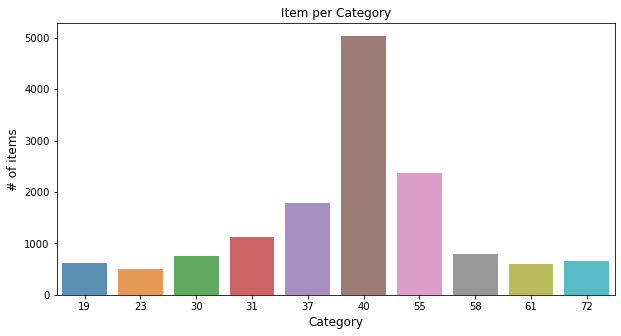

In [12]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x.item_category_id, x.item_id, alpha = 0.8)
plt.title("Item per Category")
plt.ylabel("# of items", fontsize=12)
plt.xlabel("Category", fontsize=12)
plt.show()


In [13]:
# 월별 Sales price 판단
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()

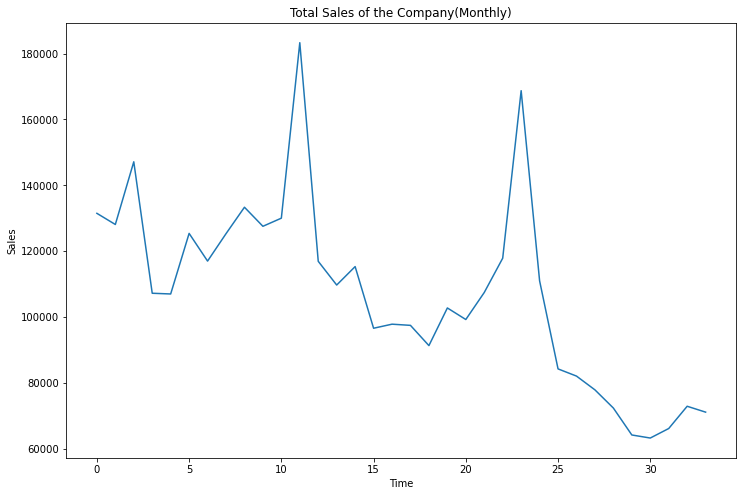

In [14]:
ts.astype('float')
plt.figure(figsize=(12,8))
plt.title("Total Sales of the Company(Monthly)")
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

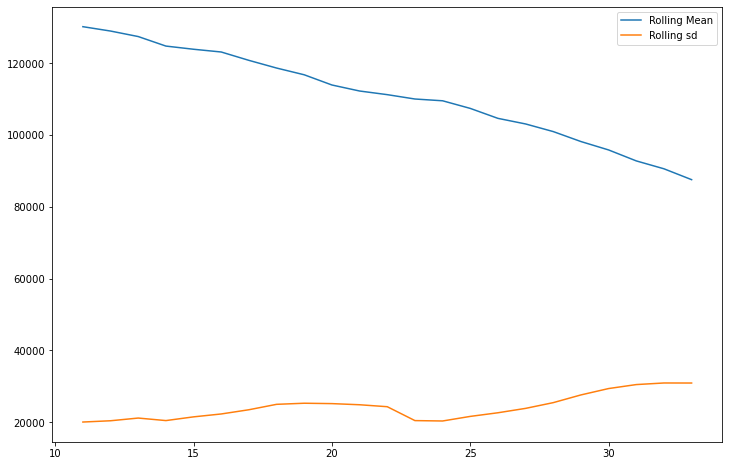

In [15]:
plt.figure(figsize=(12,8))
plt.plot(ts.rolling(window=12, center=False).mean(), label='Rolling Mean')
plt.plot(ts.rolling(window=12, center=False).std(), label='Rolling sd')
plt.legend();

- 계절성이 언뜻 보이므로 계절성을 확인해볼 필요가 보임

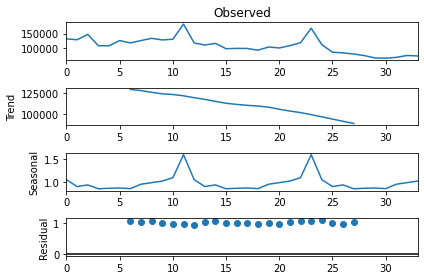

In [16]:
import statsmodels.api as sm

# multiplicative
# 승법모형 -> y = t*s*r
## 데이터에 0이 존재하면 안됨. 0이 존재하면 데이터 분해가 불가능
res = sm.tsa.seasonal_decompose(ts.values, freq=12, model="multiplicative")
fig = res.plot()

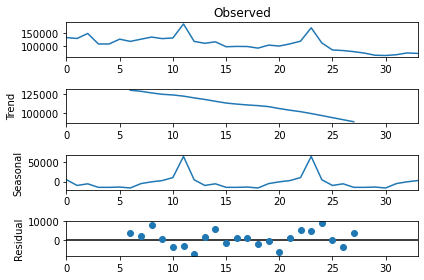

In [17]:
# additive
# 가법 모형 -> y = t+s+r
res = sm.tsa.seasonal_decompose(ts.values, freq=12, model="additive")
fig = res.plot()

### 정상성 검정 필요
- ADF(most pick)
- KPSS
- PP

In [18]:
def test_stationarity(timeseries):
    
    # Perform Dickey-Fuller test:
    print('Result of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(ts)

Result of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [19]:
# to remove trend
from pandas import Series as Series
def difference(dataset, interval = 1):
    diff= list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

def inverse_difference(last_ob, value):
    return value + last_ob


[]

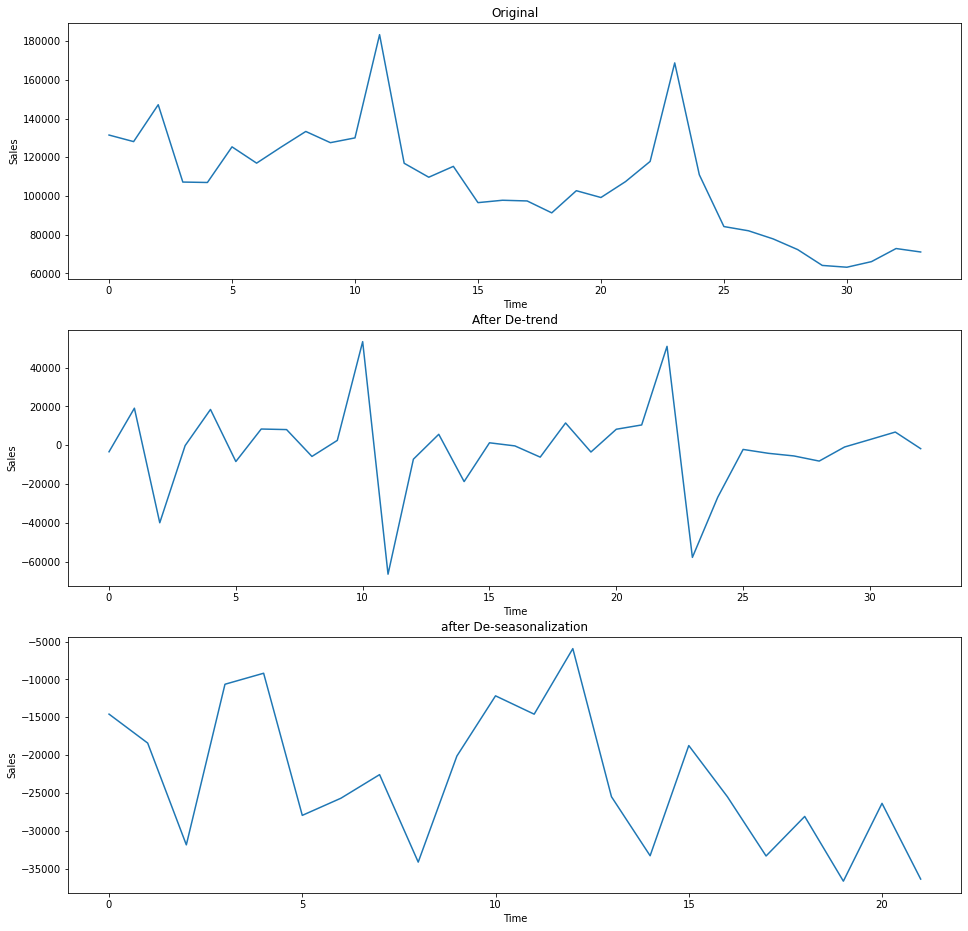

In [20]:
ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts = difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title("after De-seasonalization")
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts = difference(ts,12)
plt.plot(new_ts)
plt.plot()

In [21]:
test_stationarity(new_ts)

Result of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


- p-value가 5%하 유의함을 알 수 있었음. 정상성 만족.

In [22]:
def tsplot(y, lags=None, figsize=(10,8), style='bmh', title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()
    return

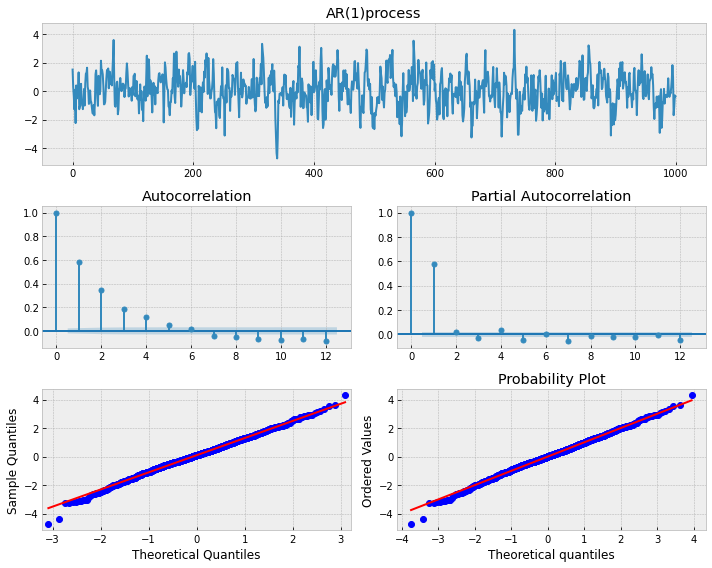

In [23]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1]+w[t]
limit = 12
_ = tsplot(x, lags=limit, title='AR(1)process')

- ACF는 expoentially한 부분이 없고 pacf는 lag=1에서 cutting off를 보임

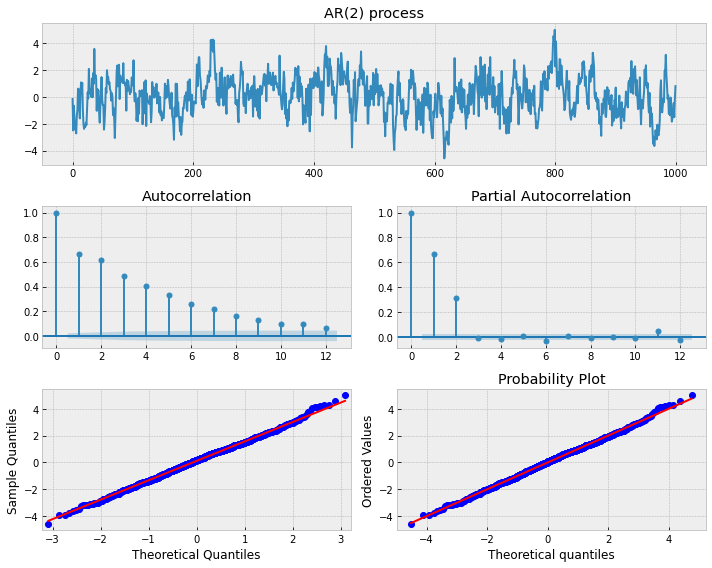

In [24]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

- acf에서 expoentially한 모습을 보이지 않고 pacf lag=2에서 cutting off를 보임

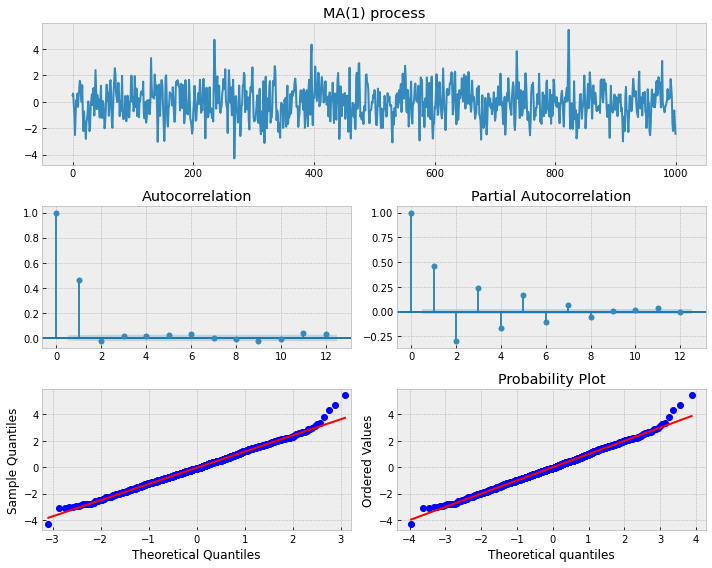

In [25]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

- acf lag =1 에서 cut off 보임

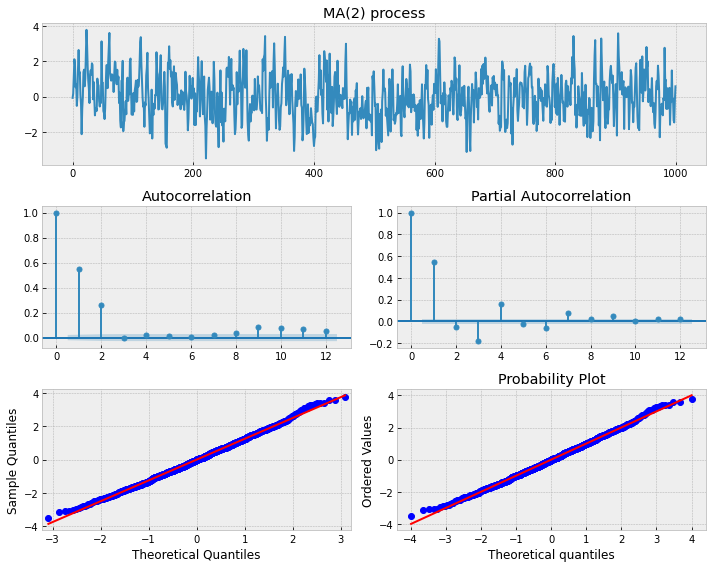

In [26]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

- acf lag = 2에서 cut off를 보임

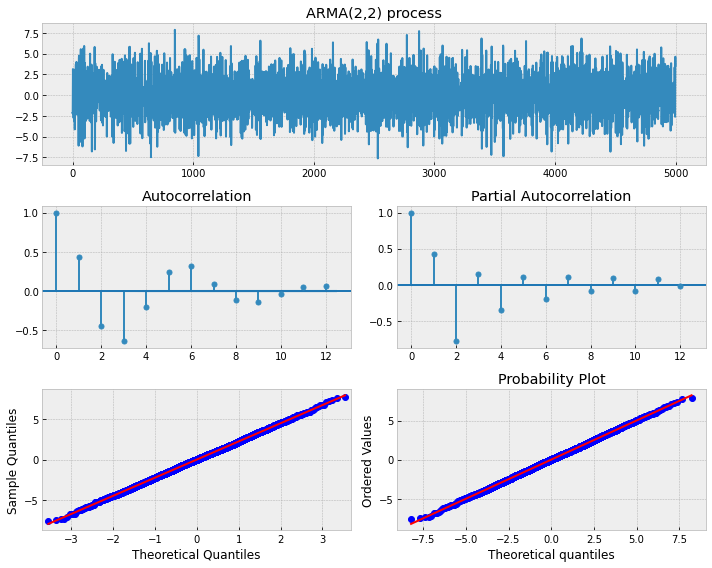

In [27]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

In [28]:
# pick nest ordere by aic
# smallest aic value pick

best_aic = np.inf
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i,j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i,j)
                best_mdl = tmp_mdl
        except : continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15326.68109 | order: (2, 2)


- ARMA(2,2)가 가장 좋은 모델로 선정됨

In [29]:
# Sales time-series 적용
best_aic = np.inf
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 472.99703 | order: (1, 1)


In [30]:
ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts

date_block_num
0     131479.0
1     128090.0
2     147142.0
3     107190.0
4     106970.0
5     125381.0
6     116966.0
7     125291.0
8     133332.0
9     127541.0
10    130009.0
11    183342.0
12    116899.0
13    109687.0
14    115297.0
15     96556.0
16     97790.0
17     97429.0
18     91280.0
19    102721.0
20     99208.0
21    107422.0
22    117845.0
23    168755.0
24    110971.0
25     84198.0
26     82014.0
27     77827.0
28     72295.0
29     64114.0
30     63187.0
31     66079.0
32     72843.0
33     71056.0
Name: item_cnt_day, dtype: float64

In [31]:
# adding the dates to the Time-series as index
ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index = pd.date_range(start = '2013-01-01', end = '2015-10-01', freq = "MS")
ts = ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


In [32]:
from fbprophet import Prophet
ts.columns = ['ds','y']
model = Prophet(yearly_seasonality = True)
model.fit(ts)

Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [33]:
future = model.make_future_dataframe(periods = 5, freq='MS')
forecast = model.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83193.957240,80157.850210,86253.821900
35,2015-12-01,125513.062950,122507.614806,128527.676856
36,2016-01-01,75625.688527,72334.504326,78761.262052
37,2016-02-01,40109.144436,36826.924007,43146.889440
38,2016-03-01,76664.084670,73570.379876,79724.131861


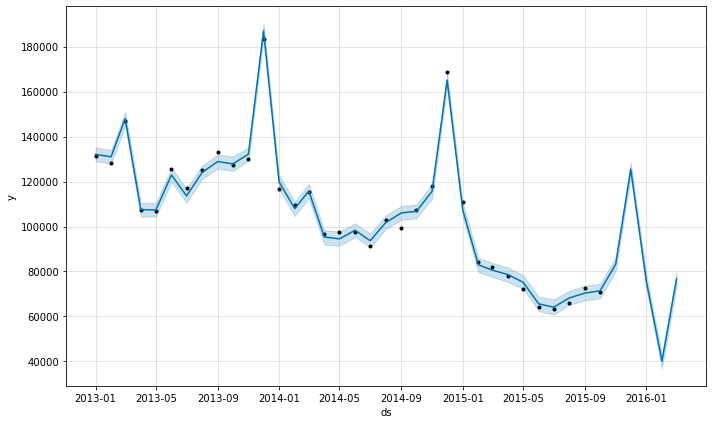

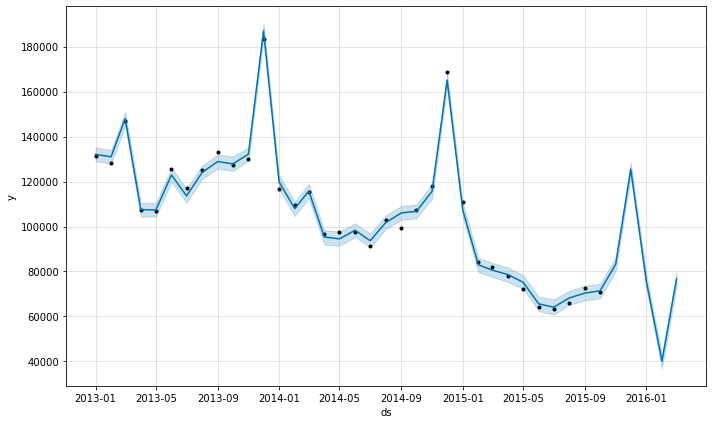

In [34]:
model.plot(forecast)

- period = 5이므로 5달의 예측치를 나타냄

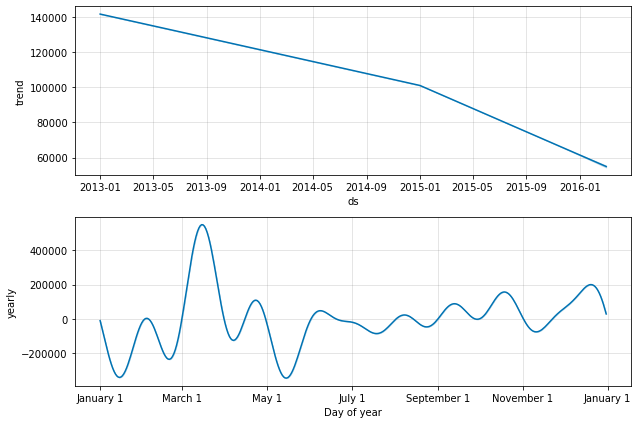

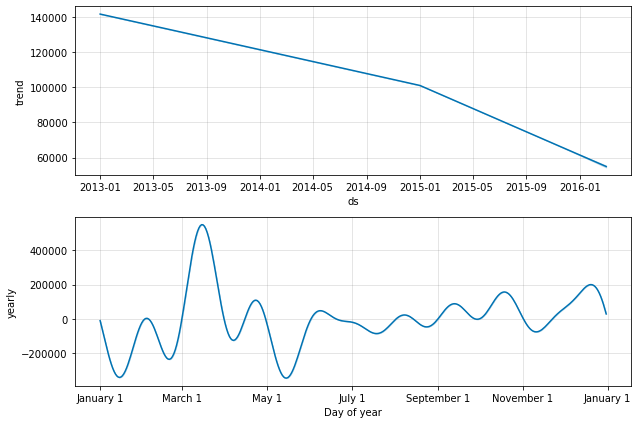

In [35]:
model.plot_components(forecast)

- Trend와 seasonality를 나타냄

In [36]:
total_sales=sales.groupby(['date_block_num'])["item_cnt_day"].sum()
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')

total_sales.index=dates
total_sales.head()

2013-01-01    131479.0
2013-02-01    128090.0
2013-03-01    147142.0
2013-04-01    107190.0
2013-05-01    106970.0
Freq: MS, Name: item_cnt_day, dtype: float64

In [37]:
# get the unique combinations of item-store from the sales data at monthly level
monthly_sales = sales.groupby(['shop_id','item_id','date_block_num'])['item_cnt_day'].sum()
monthly_sales

shop_id  item_id  date_block_num
0        30       1                 31.0
         31       1                 11.0
         32       0                  6.0
                  1                 10.0
         33       0                  3.0
                                    ... 
59       22164    27                 2.0
                  30                 1.0
         22167    9                  1.0
                  11                 2.0
                  17                 1.0
Name: item_cnt_day, Length: 1609124, dtype: float64

In [38]:
monthly_sales = monthly_sales.unstack(level=-1).fillna(0)
monthly_sales

date_block_num    0     1    2    3    4    5    6    7    8    9   ...   24  \
shop_id item_id                                                     ...        
0       30       0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        31       0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        32       6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        33       3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        35       1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
...              ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
59      22154    1.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22155    0.0   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0   
        22162    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22164    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22167    0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
0       30       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...              ...  ...  ...  ...  ...  ...  ...  ...  ...  
59      22154    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        22155    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        22162    9.0  4.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  
        22164    2.0  1.0  2.0  0.0  0.0  1.0  0.0  0.0  0.0  
        22167    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[424124 rows x 34 columns]

In [39]:
monthly_sales = monthly_sales.T
monthly_sales

shop_id           0                                                         \
item_id        30    31    32    33    35    36    40    42    43    49      
date_block_num                                                               
0                0.0   0.0   6.0   3.0   1.0   0.0   0.0   0.0   1.0   0.0   
1               31.0  11.0  10.0   3.0  14.0   1.0   1.0   1.0   0.0   2.0   
2                0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3                0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4                0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5                0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
6                0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
7                0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
8                0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
9                0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
10               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
11               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
12               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
13               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
14               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
15               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
16               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
17               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
18               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
19               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
20               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
21               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
22               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
23               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
24               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
25               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
26               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
27               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
28               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
29               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
30               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
31               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
32               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
33               0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

shop_id         ...    59                                                  \
item_id         ... 22144 22145 22150 22151 22153 22154 22155 22162 22164   
date_block_num  ...                                                         
0               ...   0.0   0.0   0.0   2.0   0.0   1.0   0.0   0.0   0.0   
1               ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2               ...   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   
3               ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4               ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5               ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
6               ...   0.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0   
7               ...   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
8               ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
9               ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
10              ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
11              ...   0.0   0.0   0

In [40]:
dates = pd.date_range(start = '2013-01-01', end = '2015-10-01', freq = 'MS')
monthly_sales.index = dates
monthly_sales = monthly_sales.reset_index()
monthly_sales

shop_id      index     0                                             ...  \
item_id               30    31    32   33    35   36   40   42   43  ...   
0       2013-01-01   0.0   0.0   6.0  3.0   1.0  0.0  0.0  0.0  1.0  ...   
1       2013-02-01  31.0  11.0  10.0  3.0  14.0  1.0  1.0  1.0  0.0  ...   
2       2013-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
3       2013-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
4       2013-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
5       2013-06-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
6       2013-07-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
7       2013-08-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
8       2013-09-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
9       2013-10-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
10      2013-11-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
11      2013-12-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
12      2014-01-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
13      2014-02-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
14      2014-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
15      2014-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
16      2014-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
17      2014-06-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
18      2014-07-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
19      2014-08-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
20      2014-09-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
21      2014-10-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
22      2014-11-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
23      2014-12-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
24      2015-01-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
25      2015-02-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
26      2015-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
27      2015-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
28      2015-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
29      2015-06-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
30      2015-07-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
31      2015-08-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
32      2015-09-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
33      2015-10-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   

shop_id    59                                                        
item_id 22144 22145 22150 22151 22153 22154 22155 22162 22164 22167  
0         0.0   0.0   0.0   2.0   0.0   1.0   0.0   0.0   0.0   0.0  
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6         0.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0  
7         0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
8         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
10        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
11        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0  
12        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
13        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
14        0.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
15        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
16 

In [41]:
monthly_sales

shop_id      index     0                                             ...  \
item_id               30    31    32   33    35   36   40   42   43  ...   
0       2013-01-01   0.0   0.0   6.0  3.0   1.0  0.0  0.0  0.0  1.0  ...   
1       2013-02-01  31.0  11.0  10.0  3.0  14.0  1.0  1.0  1.0  0.0  ...   
2       2013-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
3       2013-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
4       2013-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
5       2013-06-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
6       2013-07-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
7       2013-08-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
8       2013-09-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
9       2013-10-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
10      2013-11-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
11      2013-12-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
12      2014-01-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
13      2014-02-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
14      2014-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
15      2014-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
16      2014-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
17      2014-06-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
18      2014-07-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
19      2014-08-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
20      2014-09-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
21      2014-10-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
22      2014-11-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
23      2014-12-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
24      2015-01-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
25      2015-02-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
26      2015-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
27      2015-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
28      2015-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
29      2015-06-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
30      2015-07-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
31      2015-08-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
32      2015-09-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
33      2015-10-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   

shop_id    59                                                        
item_id 22144 22145 22150 22151 22153 22154 22155 22162 22164 22167  
0         0.0   0.0   0.0   2.0   0.0   1.0   0.0   0.0   0.0   0.0  
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6         0.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0  
7         0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
8         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0  
10        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
11        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0  
12        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
13        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
14        0.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
15        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
16 

In [ ]:
sns.heatmap(monthly_sales.iloc[:,1:], annot=True)